## Extract CSV Files

In [1]:
import pickle
import csv

In [2]:
def csv2dicts(csvfile):
    data = []
    keys = []
    for row_index, row in enumerate(csvfile):
        if row_index == 0:
            keys = row
            print(row)
            continue
        # if row_index % 10000 == 0:
        #     print(row_index)
        data.append({key: value for key, value in zip(keys, row)})
    return data


def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x

In [6]:
train_data = "data/train.csv"
store_data = "data/store.csv"
store_states = 'data/store_states.csv'

In [9]:
with open(train_data) as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    with open('data/train_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        data = data[::-1]
        pickle.dump(data, f, -1)
        print(data[:3])

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
[{'Store': '1115', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1114', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1113', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}]


In [15]:
with open(store_data) as csvfile, open(store_states) as csvfile2:
    data = csv.reader(csvfile, delimiter=',')
    state_data = csv.reader(csvfile2, delimiter=',')
    with open('data/store_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        state_data = csv2dicts(state_data)
        set_nan_as_string(data)  # 补充缺失值为0
        for index, val in enumerate(data):
            state = state_data[index]
            val['State'] = state['State']
            data[index] = val
        pickle.dump(data, f, -1)
        print(data[:2])


['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Store', 'State']
[{'Store': '1', 'StoreType': 'c', 'Assortment': 'a', 'CompetitionDistance': '1270', 'CompetitionOpenSinceMonth': '9', 'CompetitionOpenSinceYear': '2008', 'Promo2': '0', 'Promo2SinceWeek': '0', 'Promo2SinceYear': '0', 'PromoInterval': '0', 'State': 'HE'}, {'Store': '2', 'StoreType': 'a', 'Assortment': 'a', 'CompetitionDistance': '570', 'CompetitionOpenSinceMonth': '11', 'CompetitionOpenSinceYear': '2007', 'Promo2': '1', 'Promo2SinceWeek': '13', 'Promo2SinceYear': '2010', 'PromoInterval': 'Jan,Apr,Jul,Oct', 'State': 'TH'}]


## Prepare Features

In [12]:
import pickle
from datetime import datetime
from sklearn import preprocessing
import numpy as np
import random
random.seed(42)

In [16]:
with open('data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)
    num_records = len(train_data)
with open('data/store_data.pickle', 'rb') as f:
    store_data = pickle.load(f)

In [19]:
def feature_list(record):
    dt = datetime.strptime(record['Date'], '%Y-%m-%d')
    store_index = int(record['Store'])
    year = dt.year
    month = dt.month
    day = dt.day
    day_of_week = int(record['DayOfWeek'])
    try:
        store_open = int(record['Open'])
    except:
        store_open = 1

    promo = int(record['Promo'])

    return [store_open,
            store_index,
            day_of_week,
            promo,
            year,
            month,
            day,
            store_data[store_index - 1]['State']
            ]

In [23]:
train_data_X = []
train_data_y = []

for record in train_data:
    if record['Sales'] != '0' and record['Open'] != '':
        fl = feature_list(record)
        train_data_X.append(fl)
        train_data_y.append(int(record['Sales']))
print("Number of train datapoints: ", len(train_data_y))

print(min(train_data_y), max(train_data_y))

Number of train datapoints:  844338
46 41551


In [35]:
full_X = train_data_X
full_X = np.array(full_X)

train_data_X = np.array(train_data_X)
les = []
for i in range(train_data_X.shape[1]):
    le = preprocessing.LabelEncoder()   # 将特征进行 LabelEncoder
    le.fit(full_X[:, i])
    les.append(le)
    train_data_X[:, i] = le.transform(train_data_X[:, i])

with open('data/les.pickle', 'wb') as f:
    pickle.dump(les, f, -1)


In [39]:
train_data_X = train_data_X.astype(int)
train_data_y = np.array(train_data_y)

with open('data/feature_train_data.pickle', 'wb') as f:
    pickle.dump((train_data_X, train_data_y), f, -1)
    print(train_data_X[0], train_data_y[0])

[  0 109   1   0   0   0   0   7] 5961


## Model

In [58]:
import pickle
import numpy
numpy.random.seed(123)
from models import embed_features, NN_with_EntityEmbedding
from sklearn.preprocessing import OneHotEncoder
import sys
sys.setrecursionlimit(10000)  # 设置递归调用深度

In [45]:
train_ratio = 0.9
shuffle_data = False
one_hot_as_input = False
embeddings_as_input = False
save_embeddings = True
saved_embeddings_fname = "data/embeddings.pickle"  # set save_embeddings to True to create this file

In [46]:
f = open('data/feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)

In [49]:
num_records = len(X)
train_size = int(train_ratio * num_records)

if shuffle_data:
    print("Using shuffled data")
    sh = numpy.arange(X.shape[0])
    numpy.random.shuffle(sh)
    X = X[sh]
    y = y[sh]

In [53]:
if embeddings_as_input:
    print("Using learned embeddings as input")
    X = embed_features(X, saved_embeddings_fname)

In [54]:
if one_hot_as_input:
    print("Using one-hot encoding as input")
    enc = OneHotEncoder(sparse=False)
    enc.fit(X)
    X = enc.transform(X)

In [55]:
X_train = X[:train_size]
X_val = X[train_size:]
y_train = y[:train_size]
y_val = y[train_size:]

In [56]:
def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = numpy.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

In [57]:
X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
print("Number of samples used for training: " + str(y_train.shape[0]))

Number of samples used for training: 200000


In [62]:
models = []

print("Fitting NN_with_EntityEmbedding...")
for i in range(5):
    models.append(NN_with_EntityEmbedding(X_train, y_train, X_val, y_val))

W0906 14:05:28.935847 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 14:05:28.998001 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 14:05:29.020044 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Fitting NN_with_EntityEmbedding...


W0906 14:05:29.211302 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 14:05:29.474086 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 14:05:29.642403 4514731456 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 200000 samples, validate on 84434 samples
Epoch 1/10
200000/200000 [==============================] - 12s 61us/step - loss: 0.0143 - val_loss: 0.0116
Epoch 2/10
200000/200000 [==============================] - 12s 58us/step - loss: 0.0094 - val_loss: 0.0106
Epoch 3/10
200000/200000 [==============================] - 12s 58us/step - loss: 0.0085 - val_loss: 0.0101
Epoch 4/10
200000/200000 [==============================] - 12s 59us/step - loss: 0.0080 - val_loss: 0.0096
Epoch 5/10
200000/200000 [==============================] - 12s 58us/step - loss: 0.0077 - val_loss: 0.0100
Epoch 6/10
200000/200000 [==============================] - 12s 60us/step - loss: 0.0075 - val_loss: 0.0096
Epoch 7/10
200000/200000 [==============================] - 12s 58us/step - loss: 0.0073 - val_loss: 0.0097
Epoch 8/10
200000/200000 [==============================] - 12s 62us/step - loss: 0.0071 - val_loss: 0.0092
Epoch 9/10
200000/200000 [==============================] - 12s 62us/step - loss: 0.0

In [63]:
if save_embeddings:
    model = models[0].model
    store_embedding = model.get_layer('store_embedding').get_weights()[0]
    dow_embedding = model.get_layer('dow_embedding').get_weights()[0]
    year_embedding = model.get_layer('year_embedding').get_weights()[0]
    month_embedding = model.get_layer('month_embedding').get_weights()[0]
    day_embedding = model.get_layer('day_embedding').get_weights()[0]
    german_states_embedding = model.get_layer('state_embedding').get_weights()[0]
    with open(saved_embeddings_fname, 'wb') as f:
        pickle.dump([store_embedding, dow_embedding, year_embedding,
                     month_embedding, day_embedding, german_states_embedding], f, -1)

In [64]:
def evaluate_models(models, X, y):
    assert(min(y) > 0)
    guessed_sales = numpy.array([model.guess(X) for model in models])
    mean_sales = guessed_sales.mean(axis=0)
    relative_err = numpy.absolute((y - mean_sales) / y)
    result = numpy.sum(relative_err) / len(y)
    return result

In [65]:
print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_models(models, X_train, y_train)
print(r_train)

print("Validation error...")
r_val = evaluate_models(models, X_val, y_val)
print(r_val)

Evaluate combined models...
Training error...
0.06352406416860196
Validation error...
0.09537375362641082


## Plot Embeddings

In [66]:
import pickle
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [67]:
with open("data/embeddings.pickle", 'rb') as f:
    [store_embedding, dow_embedding, year_embedding,
     month_embedding, day_embedding, german_states_embedding] = pickle.load(f)

In [68]:
# Load LabelEncoders
with open("data/les.pickle", 'rb') as f:
    les = pickle.load(f)
le_store = les[1]
le_dow = les[2]
le_month = les[5]
le_day = les[6]
le_state = les[7]

In [69]:
list(le_state.classes_)

['BE', 'BW', 'BY', 'HB,NI', 'HE', 'HH', 'NW', 'RP', 'SH', 'SN', 'ST', 'TH']

In [71]:
states_names = ['Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']

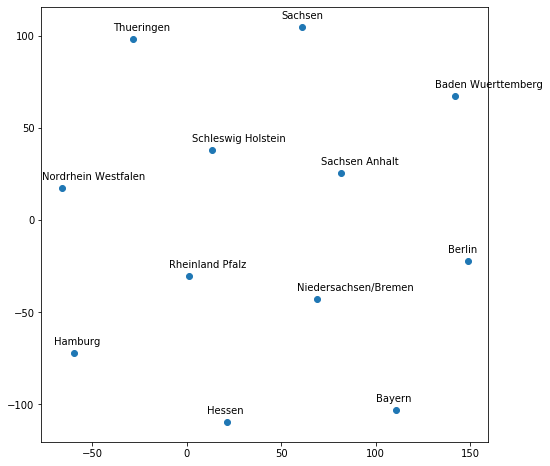

In [72]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(german_states_embedding)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(states_names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

In [73]:
list(le_dow.classes_)

['1', '2', '3', '4', '5', '6', '7']

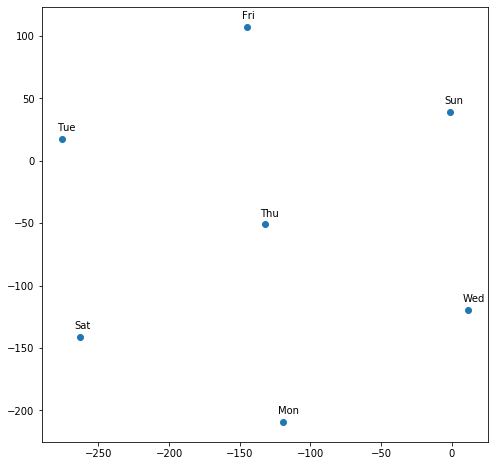

In [74]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(dow_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [75]:
list(le_month.classes_)

['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

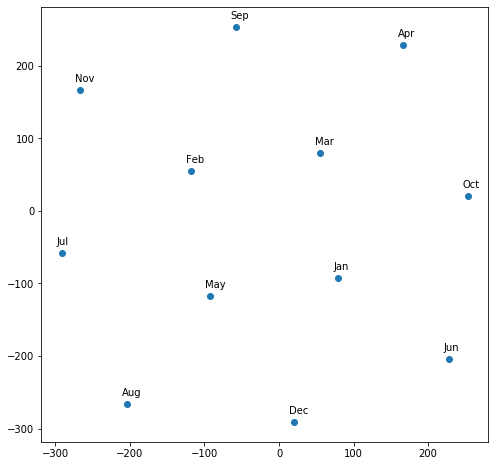

In [76]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(month_embedding)
names = ['Jan', 'Oct', 'Nov', 'Dec', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1115
[t-SNE] Computed conditional probabilities for sample 1115 / 1115
[t-SNE] Mean sigma: 0.095219
[t-SNE] Iteration 50: error = 1.4167017, gradient norm = 0.0013585 (50 iterations in 2.341s)
[t-SNE] Iteration 100: error = 1.3367173, gradient norm = 0.0006341 (50 iterations in 2.422s)
[t-SNE] Iteration 150: error = 1.3067962, gradient norm = 0.0003597 (50 iterations in 2.356s)
[t-SNE] Iteration 200: error = 1.2915353, gradient norm = 0.0002698 (50 iterations in 2.361s)
[t-SNE] Iteration 250: error = 1.2825852, gradient norm = 0.0001809 (50 iterations in 2.276s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.282585
[t-SNE] Iteration 300: error = 1.2755740, gradient norm = 0.0001510 (50 iterations in 2.347s)
[t-SNE] Iteration 350: error = 1.2682997, gradient norm = 0.0000781 (50 iterations in 2.693s)
[t-SNE] Iteration 400: error = 1.2646362, gradient norm = 0.00005

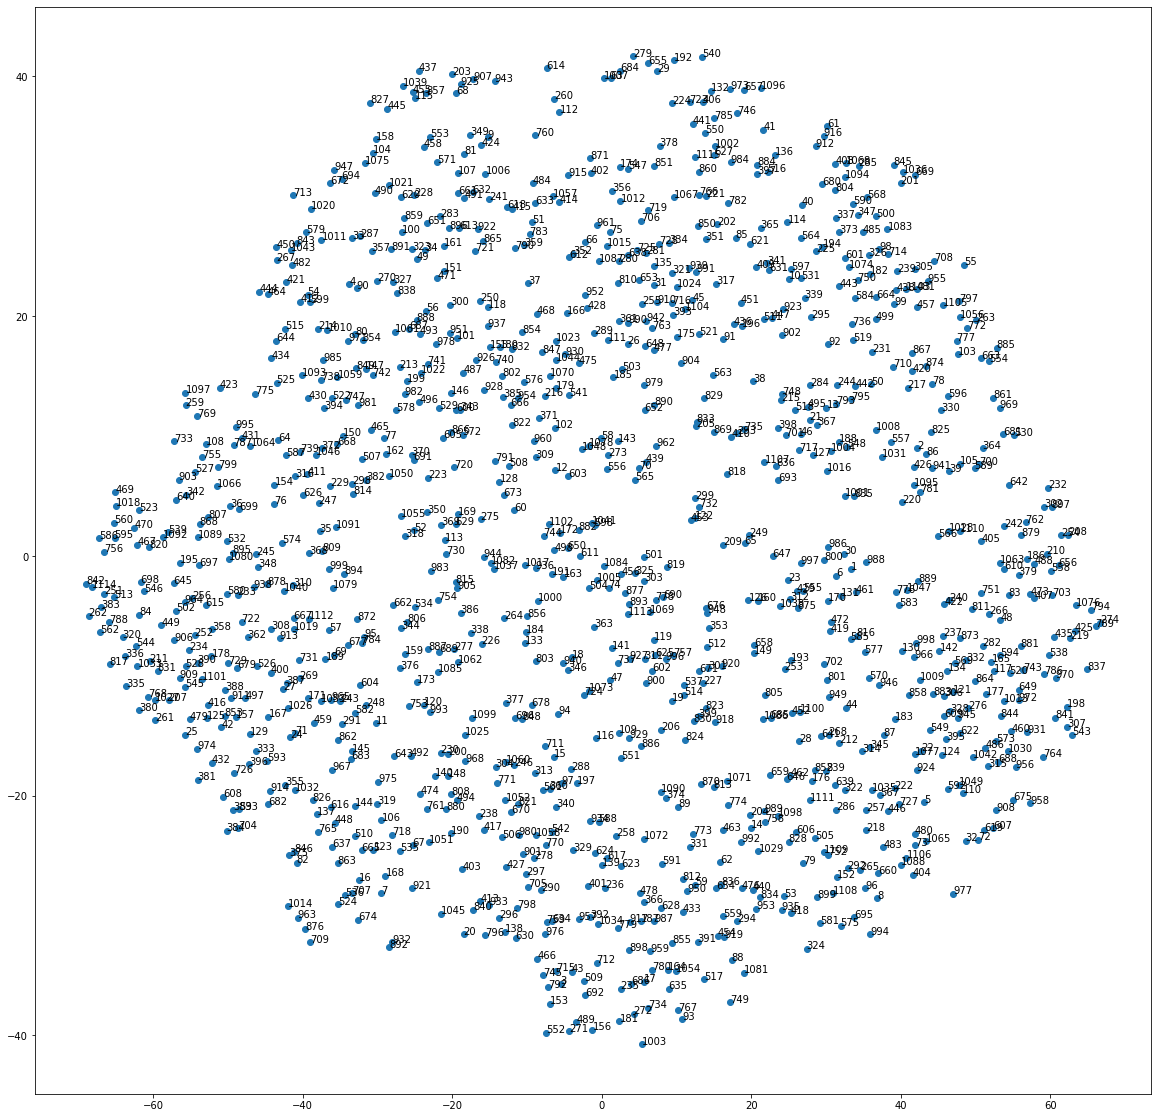

In [77]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', learning_rate=500, verbose=2, early_exaggeration=1)
Y = tsne.fit_transform(store_embedding)
names = list(le_store.classes_)
plt.figure(figsize=(20,20))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))